In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
from skimage.feature import hog
from sklearn.utils import shuffle

    
from keras.models import Sequential
from keras.models import Model
from keras.layers import ELU
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Lambda
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from keras.regularizers import l2
from keras.models import model_from_json

from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

import simplejson as json


Using TensorFlow backend.


In [56]:

# Read and make a list of calibration images
imageDirectories = []
y_train = []
indx = 0
for file in os.listdir("vehicles"):  
    imageDirectories.append("./vehicles/"+file)
    if indx%2 == 0:
        y_train.append(2)    
    else:
        y_train.append(4) 
    indx+=1
    
for file in os.listdir("non-vehicles"):  
    imageDirectories.append("./non-vehicles/"+file)
    if indx%2 ==0 :
        y_train.append(1)
    else:
        y_train.append(0)
    indx+=1
print(len(imageDirectories))
print(imageDirectories[0])

imageDirectories = np.asarray(imageDirectories)
y_train = np.asarray(y_train)

imageDirectories, y_train = shuffle(imageDirectories, y_train)


x_train, x_test,y_train, y_test = train_test_split(imageDirectories,y_train,test_size=0.2, random_state=0)

print(imageDirectories[0])
print(y_train.shape)

17760
./vehicles/1.png
./vehicles/3007.png
(14208,)


In [57]:
print(y_train[:600])
# TODO: One Hot encode the labels to the variable y_one_hot
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_one_hot = label_binarizer.fit_transform(y_train)
print(type(y_train))
print(y_train.shape,y_one_hot.shape)

[0 1 4 0 4 1 0 1 1 4 1 2 4 1 1 0 1 4 0 4 2 0 4 0 4 0 0 2 0 2 0 2 1 0 0 2 4
 2 1 1 2 2 4 0 0 0 1 2 2 0 0 2 2 0 4 1 1 0 1 4 0 0 0 2 4 1 1 1 0 2 1 1 1 2
 2 1 0 0 2 2 4 4 0 2 0 4 4 4 4 1 4 4 0 2 0 4 2 1 4 0 1 1 2 0 1 1 0 1 2 4 1
 2 1 0 0 0 0 0 4 0 0 1 1 0 4 0 1 2 0 2 1 4 2 4 1 0 2 4 0 2 0 0 4 1 0 2 1 2
 4 2 1 1 0 0 2 0 4 0 1 4 4 1 4 0 2 1 1 4 2 2 2 1 1 1 0 4 1 4 2 0 4 2 1 4 0
 0 4 4 4 0 1 1 2 4 1 4 0 4 2 1 1 2 0 0 0 2 2 1 0 4 4 0 0 2 0 2 2 2 2 4 4 4
 2 2 1 2 0 1 0 2 4 0 0 1 4 4 1 2 0 4 4 2 0 4 2 1 0 1 1 0 1 0 1 2 0 1 1 0 0
 0 1 1 4 0 2 0 4 1 1 1 4 0 4 2 2 1 2 2 4 0 2 4 2 0 1 2 0 2 0 4 4 2 0 2 0 0
 4 4 4 2 1 1 1 1 1 1 4 1 2 0 2 2 2 4 0 2 0 0 1 0 1 1 0 0 0 4 0 4 4 1 0 0 4
 1 2 4 0 2 0 0 0 4 1 4 1 0 0 0 4 1 4 0 0 1 4 0 4 0 4 1 4 2 2 1 0 4 4 0 0 1
 0 2 4 0 0 1 1 0 4 2 2 4 4 1 2 0 1 4 2 0 2 2 2 0 2 4 4 2 1 1 2 1 1 1 2 0 2
 4 1 1 2 2 1 1 2 1 0 0 1 2 4 4 2 4 0 2 2 2 4 2 4 1 4 0 1 0 4 4 0 4 2 2 1 4
 1 4 1 4 0 4 0 1 4 1 0 0 4 1 4 0 4 0 0 0 2 0 4 4 1 2 2 1 4 4 4 1 0 4 2 2 1
 0 1 2 2 1 2 4 4 2 1 1 4 

In [26]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [27]:
trainBatchSize = 256
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (64,64)
hist_bins = 32
ystart = 400
ystop = 656
scale = 1

train_samples_per_epoch = 2560
valid_samples_per_epoch = 16384


In [32]:

# Define a single function that can extract features using hog sub-sampling and make predictions
def TrainDataGenerator(x_train,y_train,scale, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    x_batch, y_batch = [], []
    while True:
        for indx,fname in enumerate(x_train):

            img = mpimg.imread(fname) #opens images in BGR format    

            img = img.astype(np.float32)/255
            
            ctrans_tosearch = convert_color(img, conv='RGB2YCrCb')
            if scale != 1:
                imshape = ctrans_tosearch.shape
                ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

            ch1 = ctrans_tosearch[:,:,0]
            ch2 = ctrans_tosearch[:,:,1]
            ch3 = ctrans_tosearch[:,:,2]

            # Compute individual channel HOG features for the entire image
            hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=True)
            hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=True)
            hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=True)

            hog_features = np.hstack((hog1, hog2, hog3))        

            # Get color features
            spatial_features = bin_spatial(ctrans_tosearch, size=spatial_size)
            hist_features = color_hist(ctrans_tosearch, nbins=hist_bins)

            
            #print(hog_features.shape)
            #print(spatial_features.shape)
            #print(hist_features.shape)
            # Scale features and make a prediction
            test_features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)  
            x_batch.append(test_features)
            y_batch.append(y_train[indx])
            #print("input Shape: ",test_features.shape)
            #break
            if(len(x_batch) == trainBatchSize):
                X = np.vstack(x_batch).astype(np.float64)
                X_scaler = StandardScaler().fit(X)
                # Apply the scaler to X
                scaled_X = X_scaler.transform(X)
                
                yield (scaled_X,np.vstack(y_batch))
                x_batch, y_batch = [], []
        #break


In [33]:
trainGenerator = TrainDataGenerator(x_train,y_train,scale, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
validGenerator = TrainDataGenerator(x_test,y_test,scale, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

(5292,)
(12288,)
(96,)
input Shape:  (1, 17676)


In [ ]:


def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


'''# Read a color image
img = cv2.imread("images/000275.png")

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

img = cv2.imread("images/25.png")

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()'''

# Read a color image
img = cv2.imread("images/000275.png")

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb,axis_labels=list("LUV"))
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HLS"))
plt.show()

img = cv2.imread("images/25.png")

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb,axis_labels=list("LUV"))
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HLS"))
plt.show()

In [24]:
### Make data frame in Pandas

import pandas as pd

rootDir = "object-detection-crowdai"
csvFile = pd.read_csv(rootDir+'/labels.csv', header=0)
dataFile = csvFile[(csvFile['Label']!='Pedestrian')].reset_index()
dataFile = dataFile.drop('index', 1)
dataFile = dataFile.drop('Preview URL', 1)
#dataFile['File_Path'] =  rootDir + '/' +dataFile['Frame']
dataFile.head()



,xmin,xmax,ymin,ymax,Frame,Label
0,785,533,905,644,1479498371963069978.jpg,Car
1,89,551,291,680,1479498371963069978.jpg,Car
2,268,546,383,650,1479498371963069978.jpg,Car
3,455,522,548,615,1479498371963069978.jpg,Truck
4,548,522,625,605,1479498371963069978.jpg,Truck


In [27]:
train_samples_per_epoch = 2560
valid_samples_per_epoch = 16384
trainBatchSize = 64
validationBatchSize = 64
imgRow = 640
imgCol = 960
def TrainDataGenerator(dataInfo,batchSize,rootDir):
    batch_x, batch_y = [], []
    while True:
        row = 0
        while row < len(dataInfo):

            fileName = './'+rootDir + '/' +dataInfo['Frame'][row]        
            #print(fileName, row)
            img = cv2.imread(fileName)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            origShape = img.shape
            img = cv2.resize(img,(imgCol,imgRow))

            data = dataInfo[dataInfo['Frame'][row] == dataInfo['Frame']].reset_index()
            data['xmin'] = np.round(data['xmin']/origShape[1] * imgCol)
            data['xmax'] = np.round(data['xmax']/origShape[1] * imgCol)
            data['ymin'] = np.round(data['ymin']/origShape[0] * imgRow)
            data['ymax'] = np.round(data['ymax']/origShape[0] * imgRow)


            targetImg = np.reshape(np.zeros_like(img[:,:,2]),(imgRow,imgCol,1))            
            for i in range(len(data)):
                targetImg[data.iloc[i]['xmax']:data.iloc[i]['ymax'],data.iloc[i]['xmin']:data.iloc[i]['ymin']] = 1
                cv2.rectangle(img, (int(data.iloc[i]['xmin']),int(data.iloc[i]['xmax'])), (int(data.iloc[i]['ymin']),int(data.iloc[i]['ymax'])), (0,0,255),6)
                #print(data.iloc[i]['xmin'],data.iloc[i]['xmax'], data.iloc[i]['ymin'],data.iloc[i]['ymax'])            

            row += len(data)-1

            batch_x.append(img)
            batch_y.append(targetImg)
            print(targetImg.shape)
            plt.imshow(targetImg)
            plt.show()
            if(len(batch_x) == batchSize):                
                #yield (np.vstack(batch_x),np.vstack(batch_y))
                x_array = np.asarray(batch_x)
                y_array = np.asarray(batch_y)
                #yield (x_array,y_array)
                batch_x, batch_y = [], []            
            row+=1        
            break
        break
trainGenerator = TrainDataGenerator(dataFile,trainBatchSize,rootDir)    

(640, 960, 1)


TypeError: Invalid dimensions for image data

In [30]:

def CreateModel():
    input_layer = Input((imgRow, imgCol, 3))
    conv1 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(input_layer)
    conv1 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    #conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    #conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)

    up5 = merge([UpSampling2D(size=(2, 2))(conv4), conv3], mode='concat', concat_axis=3)
    conv5 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up5)
    conv5 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv2], mode='concat', concat_axis=3)
    conv6 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv1], mode='concat', concat_axis=3)
    conv7 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv7)
    
    conv8 = Convolution2D(1, 1, 1, activation='sigmoid')(conv7)

    model = Model(input=input_layer, output=conv8)

    model.compile(optimizer=Adam(lr=1e-4), loss="mse", metrics=['accuracy'])

    return model



model = CreateModel()

trainGenerator = TrainDataGenerator(dataFile,trainBatchSize,rootDir)  
#trainGenerator = TrainDataGenerator(trainBatchSize)

weight_save_callback = ModelCheckpoint('./weights/weights.{epoch:02d}-{loss:.4f}.h5', monitor='loss', verbose=2, save_best_only=False, mode='auto')
model.summary()

print("Created generator and call backs. Starting training")

model.fit_generator(
    trainGenerator,
    samples_per_epoch=train_samples_per_epoch, nb_epoch=40,
    #validation_data=validGenerator,
    #nb_val_samples=valid_samples_per_epoch,
    callbacks=[weight_save_callback],
    verbose=2
)

model.save_weights('model.h5', True)
with open('model.json', 'w') as file:
    json.dump(model.to_json(), file)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_14 (InputLayer)            (None, 640, 960, 3)   0                                            
____________________________________________________________________________________________________
convolution2d_196 (Convolution2D (None, 640, 960, 16)  448         input_14[0][0]                   
____________________________________________________________________________________________________
convolution2d_197 (Convolution2D (None, 640, 960, 16)  2320        convolution2d_196[0][0]          
____________________________________________________________________________________________________
maxpooling2d_53 (MaxPooling2D)   (None, 320, 480, 16)  0           convolution2d_197[0][0]          
___________________________________________________________________________________________

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


ResourceExhaustedError: OOM when allocating tensor with shape[64,16,640,960]
	 [[Node: Conv2D_196 = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](Relu_182, convolution2d_197_W/read)]]
	 [[Node: Mean_59/_77 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_2035_Mean_59", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'Conv2D_196', defined at:
  File "C:\Program Files\Anaconda3\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Program Files\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Program Files\Anaconda3\lib\site-packages\traitlets\config\application.py", line 653, in launch_instance
    app.start()
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "C:\Program Files\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "C:\Program Files\Anaconda3\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "C:\Program Files\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Program Files\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Program Files\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-30-104684bd3ab9>", line 45, in <module>
    model = CreateModel()
  File "<ipython-input-30-104684bd3ab9>", line 5, in CreateModel
    conv1 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv1)
  File "C:\Program Files\Anaconda3\lib\site-packages\keras\engine\topology.py", line 572, in __call__
    self.add_inbound_node(inbound_layers, node_indices, tensor_indices)
  File "C:\Program Files\Anaconda3\lib\site-packages\keras\engine\topology.py", line 635, in add_inbound_node
    Node.create_node(self, inbound_layers, node_indices, tensor_indices)
  File "C:\Program Files\Anaconda3\lib\site-packages\keras\engine\topology.py", line 166, in create_node
    output_tensors = to_list(outbound_layer.call(input_tensors[0], mask=input_masks[0]))
  File "C:\Program Files\Anaconda3\lib\site-packages\keras\layers\convolutional.py", line 475, in call
    filter_shape=self.W_shape)
  File "C:\Program Files\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 2627, in conv2d
    x = tf.nn.conv2d(x, kernel, strides, padding=padding)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 396, in conv2d
    data_format=data_format, name=name)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[64,16,640,960]
	 [[Node: Conv2D_196 = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](Relu_182, convolution2d_197_W/read)]]
	 [[Node: Mean_59/_77 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_2035_Mean_59", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [2]:
from keras.models import model_from_json

with open('model.json', 'r') as jfile:
    model = model_from_json(json.loads(jfile.read())) 
    print('model loaded')

model.compile(optimizer=Adam(lr=1e-4), loss="mse", metrics=['accuracy'])
weights_file = 'model.h5'
model.load_weights(weights_file)


#result = cv2.addWeighted(dst, 1, newwarp, 0.3, 0)

model loaded


In [5]:
imgRow = 424
imgCol = 640
def process_frame(img):
    plt.imshow(img)
    plt.show()
    img = cv2.resize(img,(imgCol,imgRow))
    imgShow = np.zeros_like(img)
    x_array = np.asarray(img)
    x_array = np.reshape(x_array,(1,imgRow,imgCol,3))
    print('input: ',x_array.shape)
    img = model.predict(x_array,verbose=1)
    print('output: ',img.shape)
    
    imgShow[:,:,2] = img[0][:,:,0]
    
    plt.imshow(imgShow)            
    plt.show()
    return imShow

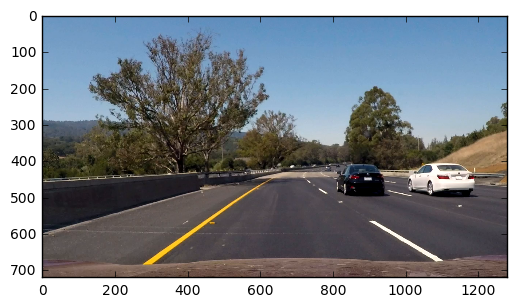

input:  (1, 424, 640, 3)
1/1 [==============================] - 0s
output:  (1, 424, 640, 1)


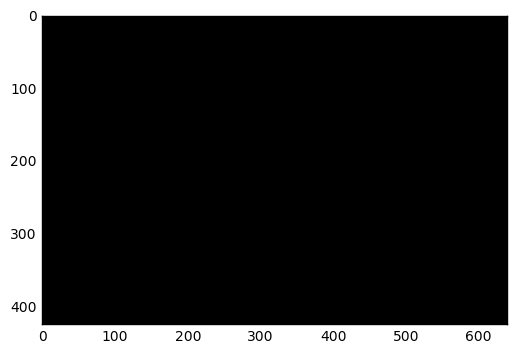

NameError: name 'imShow' is not defined

In [6]:
from moviepy.editor import VideoFileClip
clip = VideoFileClip('./test_video.mp4')
outClip = clip.fl_image(process_frame)
outClip.write_videofile('./output_video.mp4', audio=False)

In [13]:
import imageio
imageio.plugins.ffmpeg.download()

Imageio: 'ffmpeg.win32.exe' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.win32.exe (27.4 MB)
Downloading: 8192/28781056 bytes (0.0%)32768/28781056 bytes (0.1%)131072/28781056 bytes (0.5%)262144/28781056 bytes (0.9%)557056/28781056 bytes (1.9%)1097728/28781056 bytes (3.8%)1777664/28781056 bytes (6.2%)2473984/28781056 bytes (8.6%)3170304/28781056 bytes (11.0%)3784704/28781056 bytes (13.1%)4407296/28781056 bytes (15.3%)5013504/28781056 bytes (17.4%)5693440/28781056 bytes (19.8%)6365184/28781056 bytes (22.1%)